# CSE4502 Programming Assignment #3 - Eric Wang

This programming assignment has two parts.

## Part 1: Fashion MNIST

Load the fashion MNIST data set, and split it into a training set, a validation set, and a test set
(e.g., use 40,000 instances for training, 10,000 for validation, and 10,000 for testing). Then
train various classifiers, such as a Random Forest classifier, an Extra-Trees classifier, and an
MLP classifier (use code mlp_clf = MLPClassifier(random_state=42)).

Next, try to combine them into an ensemble that outperforms them all on the validation set,
using a soft or hard voting classifier. Once you have found one, try it on the test set. How much
better does it perform compared to the individual classifiers?

Run the individual classifiers to make predictions on the validation set, and create a new training
set with the resulting predictions: each training instance is a vector containing the set of
predictions from all your classifiers for an image, and the target is the image’s class.
Congratulations, you have just trained a blender, and together with the classifiers they form a
stacking ensemble! Now let’s evaluate the ensemble on the test set. For each image in the test
set, make predictions with all your classifiers, then feed the predictions to the blender to get the
ensemble’s predictions. How does it compare to the voting classifier you trained earlier?

In [18]:
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

In [19]:
#import mnist_reader
#X_train, y_train = mnist_reader.load_mnist('', kind='train')
#X_test, y_test = mnist_reader.load_mnist('', kind='t10k')

In [20]:
import mnist_reader
X_train, y_train = mnist_reader.load_mnist('', kind='train')
X_test, y_test = mnist_reader.load_mnist('', kind='t10k')

In [4]:
X_train.shape

(60000, 784)

***Now splitting the data set into training set, validation set, and test set***

In [5]:
X_train, X_val = X_train[:50000], X_train[50000:60000]
y_train, y_val = y_train[:50000], y_train[50000:60000]

***Check sizes of all sets that have been split***

In [6]:
X_train.shape

(50000, 784)

In [7]:
X_val.shape

(10000, 784)

In [8]:
X_test.shape

(10000, 784)

In [9]:
y_train.shape

(50000,)

In [10]:
y_val.shape

(10000,)

In [11]:
y_test.shape

(10000,)

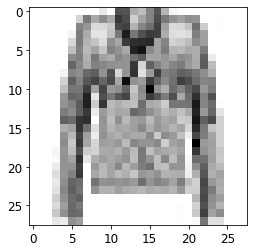

In [12]:
some_digit = X_train[36501]
some_digit_image = some_digit.reshape(28, 28)
plt.imshow(some_digit_image, cmap = matplotlib.cm.binary, interpolation="nearest")

In [13]:
# set random seed 42
np.random.seed(42)

### Training Various Classifiers

***Training 1st Classifier - Random Forest***

This Random Forest has modified hyperparameters after performing a quick random search to find the best hyperparameters

In [17]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict

In [18]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

param_distribs = {
        'n_estimators': randint(low=1, high=200),
        'max_features': randint(low=1, high=8),
    }

forest_best_clf = RandomForestClassifier(random_state=42)
rnd_search = RandomizedSearchCV(forest_best_clf, param_distributions=param_distribs,
                                n_iter=10, cv=5, scoring='neg_mean_squared_error', random_state=42)
rnd_search.fit(X_train, y_train)

RandomizedSearchCV(cv=5, error_score='raise-deprecating',
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
                                                    n_estimators='warn',
                                                    n_jobs=None

In [19]:
cvres = rnd_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

1.3056109680911845 {'max_features': 7, 'n_estimators': 180}
1.4052188441662743 {'max_features': 5, 'n_estimators': 15}
1.3546512466313978 {'max_features': 3, 'n_estimators': 72}
1.3876022484847739 {'max_features': 5, 'n_estimators': 21}
1.3070348120842077 {'max_features': 7, 'n_estimators': 122}
1.3556031867770155 {'max_features': 3, 'n_estimators': 75}
1.3552564332996173 {'max_features': 3, 'n_estimators': 88}
1.3256620987265193 {'max_features': 5, 'n_estimators': 100}
1.3409399688278367 {'max_features': 3, 'n_estimators': 150}
1.7962961893852583 {'max_features': 5, 'n_estimators': 2}


In [20]:
rnd_search.best_params_

{'max_features': 7, 'n_estimators': 180}

In [21]:
forest_best_clf = rnd_search.best_estimator_

In [22]:
forest_best_clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features=7, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=180,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [23]:
#cross_val_score(forest_best_clf, X_train, y_train, cv=3, scoring="accuracy")

array([0.87101806, 0.87287017, 0.87397227])

In [24]:
y_pred_forest = forest_best_clf.predict(X_test)

from sklearn import metrics
best_forest_accuracy = metrics.accuracy_score(y_test, y_pred_forest)
print("Random Forest Accuracy:", best_forest_accuracy)
print("Random Forest Accuracy Percentage", best_forest_accuracy * 100, "%")

Random Forest Accuracy: 0.8671
Random Forest Accuracy Percentage 86.71 %


***Training 2nd Classifier - Support Vector Machine Classifier*** 

Gamma set to "auto" so that the SVM Classifier figures out itself for which type of SVM to use

In [40]:
from sklearn.svm import LinearSVC

svm_clf = LinearSVC(random_state=42)
svm_clf.fit(X_train, y_train)

C:\Users\EcW78\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=42, tol=0.0001,
          verbose=0)

In [26]:
#cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

array([0.82386466, 0.79277658, 0.80141631])

In [27]:
y_pred_sgd = sgd_clf.predict(X_test)

from sklearn import metrics
best_sgd_accuracy = metrics.accuracy_score(y_test, y_pred_sgd)
print("SVM Accuracy:", best_sgd_accuracy)
print("SVM Accuracy in Percentage", best_sgd_accuracy * 100, "%")

SGD Accuracy: 0.7601
SGD Accuracy in Percentage 76.01 %


***Training 3rd Classifier - Extra-Trees Classifier*** 

Random Search is used again to find the best parameters for the Extra Trees Classifier

In [28]:
from sklearn.ensemble import ExtraTreesClassifier

In [29]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint
  
extratree_clf = ExtraTreesClassifier(random_state=42)

In [30]:
extratree_clf.fit(X_train, y_train)

C:\Users\EcW78\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
                     max_depth=None, max_features='auto', max_leaf_nodes=None,
                     min_impurity_decrease=0.0, min_impurity_split=None,
                     min_samples_leaf=1, min_samples_split=2,
                     min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
                     oob_score=False, random_state=42, verbose=0,
                     warm_start=False)

In [31]:
#cross_val_score(extratree_clf, X_train, y_train, cv=3, scoring="accuracy")

array([0.84852121, 0.8512119 , 0.85290764])

In [32]:
y_pred_extratree = extratree_clf.predict(X_test)

from sklearn import metrics
extratree_accuracy = metrics.accuracy_score(y_test, y_pred_extratree)
print("Extra Tree Accuracy:", extratree_accuracy)
print("Extra Tree Accuracy Percentage", extratree_accuracy * 100, "%")

Extra Tree Accuracy: 0.8459
Extra Tree Accuracy Percentage 84.59 %


***Training 4th Classifier - MLP***

MLP (Multi-layer Perceptron) Classifier, uses Stochastic Gradient Descent or log-loss function LBFGS (Broygen-Fletcher-Goldfarb-Shanno) Algorithms

In [33]:
from sklearn.neural_network import MLPClassifier

mlp_clf = MLPClassifier(random_state=42)

In [34]:
#cross_val_score(mlp_clf, X_train, y_train, cv=3, scoring="accuracy")

array([0.85739996, 0.85415167, 0.85626838])

In [35]:
mlp_clf.fit(X_train, y_train)

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(100,), learning_rate='constant',
              learning_rate_init=0.001, max_iter=200, momentum=0.9,
              n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
              random_state=42, shuffle=True, solver='adam', tol=0.0001,
              validation_fraction=0.1, verbose=False, warm_start=False)

In [36]:
y_pred_mlp = mlp_clf.predict(X_test)

from sklearn import metrics
best_mlp_accuracy = metrics.accuracy_score(y_test, y_pred_mlp)
print("MLP Accuracy:", best_mlp_accuracy)
print("MLP Accuracy Percentage", best_mlp_accuracy * 100, "%")

MLP Accuracy: 0.8472
MLP Accuracy Percentage 84.72 %


### Training Voting Classifier

In [38]:
# from sklearn.ensemble import VotingClassifier

# voting_clf = VotingClassifier(
#     estimators=[('RandomForest', forest_best_clf), ('SGD', sgd_clf), ('ExtraTree', extratree_clf), ('MLP', mlp_clf)],
#     voting='hard')
# voting_clf.fit(X_train, y_train)

KeyboardInterrupt: 

In [ ]:
# from sklearn.metrics import accuracy_score

# for clf in (forest_best_clf, sgd_clf, extratree_clf, mlp_clf, voting_clf):
# #    clf.fit(X_train, y_train)     # already fitted in every training instance
#     y_pred = clf.predict(X_val)
#     print(clf.__class__.__name__, accuracy_score(y_val, y_pred))



Does not outperform

In [ ]:
# from sklearn.ensemble import VotingClassifier

# voting_clf_2 = VotingClassifier(
#     estimators=[('RandomForest', forest_best_clf), ('ExtraTree', extratree_best_clf), ('MLP', mlp_clf)],
#     voting='soft')
# voting_clf_2.fit(X_train, y_train)

In [ ]:
# from sklearn.metrics import accuracy_score

# for clf in (forest_best_clf, extratree_clf, mlp_clf, voting_clf_2):
# #    clf.fit(X_train, y_train)     # already fitted in every training instance
#     y_pred = clf.predict(X_val)
#     print(clf.__class__.__name__, accuracy_score(y_val, y_pred))

***Preivous commented out code is my previous, unsuccessful attempt***

In [43]:
estimators = [forest_best_clf, extratree_clf, svm_clf, mlp_clf]

In [44]:
[estimator.score(X_val, y_val) for estimator in estimators]

[0.8743, 0.8526, 0.7381, 0.8517]

The SVM Classifier seems to perform much worse than all other classifiers, there's a chance that it may improve the performance of the Voting Classifier, thus it will be kept in for now.

In [ ]:
from sklearn.ensemble import VotingClassifier

In [47]:
my_estimators = [
    ("random_forest_clf", forest_best_clf),
    ("extra_trees_clf", extratree_clf),
    ("svm_clf", svm_clf),
    ("mlp_clf", mlp_clf),
]

In [49]:
voting_clf = VotingClassifier(my_estimators)

In [50]:
voting_clf.fit(X_train, y_train)

C:\Users\EcW78\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


VotingClassifier(estimators=[('random_forest_clf',
                              RandomForestClassifier(bootstrap=True,
                                                     class_weight=None,
                                                     criterion='gini',
                                                     max_depth=None,
                                                     max_features=7,
                                                     max_leaf_nodes=None,
                                                     min_impurity_decrease=0.0,
                                                     min_impurity_split=None,
                                                     min_samples_leaf=1,
                                                     min_samples_split=2,
                                                     min_weight_fraction_leaf=0.0,
                                                     n_estimators=180,
                                                     n_jobs=None,


In [51]:
voting_clf.score(X_val, y_val)

0.8707

In [52]:
[estimator.score(X_val, y_val) for estimator in voting_clf.estimators_]

[0.8743, 0.8526, 0.7381, 0.8517]

Perhaps removing the SVM here would improve the performance of the overall Voting Classifier

In [53]:
voting_clf.set_params(svm_clf=None)


VotingClassifier(estimators=[('random_forest_clf',
                              RandomForestClassifier(bootstrap=True,
                                                     class_weight=None,
                                                     criterion='gini',
                                                     max_depth=None,
                                                     max_features=7,
                                                     max_leaf_nodes=None,
                                                     min_impurity_decrease=0.0,
                                                     min_impurity_split=None,
                                                     min_samples_leaf=1,
                                                     min_samples_split=2,
                                                     min_weight_fraction_leaf=0.0,
                                                     n_estimators=180,
                                                     n_jobs=None,


In [54]:
voting_clf.estimators

[('random_forest_clf',
  RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                         max_depth=None, max_features=7, max_leaf_nodes=None,
                         min_impurity_decrease=0.0, min_impurity_split=None,
                         min_samples_leaf=1, min_samples_split=2,
                         min_weight_fraction_leaf=0.0, n_estimators=180,
                         n_jobs=None, oob_score=False, random_state=42, verbose=0,
                         warm_start=False)),
 ('extra_trees_clf',
  ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
                       oob_score=False, random_state=42, verbose=0,
        

In [55]:
voting_clf.estimators_

[RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                        max_depth=None, max_features=7, max_leaf_nodes=None,
                        min_impurity_decrease=0.0, min_impurity_split=None,
                        min_samples_leaf=1, min_samples_split=2,
                        min_weight_fraction_leaf=0.0, n_estimators=180,
                        n_jobs=None, oob_score=False, random_state=42, verbose=0,
                        warm_start=False),
 ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
                      oob_score=False, random_state=42, verbose=0,
                      warm_start=False),
 LinearSVC(C=1.0, class_w

In [56]:
del voting_clf.estimators_[2]

In [57]:
voting_clf.score(X_val, y_val)

0.8737

In [58]:
voting_clf.voting = "soft"

In [59]:
voting_clf.score(X_val, y_val)

0.8745

It seems that Voting condition "soft" performs better than "hard", soft voting will be kept. Now running on the test sets

In [60]:
voting_clf.score(X_test, y_test)

0.8743

In [61]:
[estimator.score(X_test, y_test) for estimator in voting_clf.estimators_]

[0.8671, 0.8459, 0.8472]

There is an improvement in performance through the Voting Classifier, with smallest difference between Voting and Random Forrest by 0.0072

## Stacking Ensemble

In [62]:
X_val_predictions = np.empty((len(X_val), len(estimators)), dtype=np.float32)

for index, estimator in enumerate(estimators):
    X_val_predictions[:, index] = estimator.predict(X_val)

In [63]:
X_val_predictions

array([[9., 9., 9., 9.],
       [2., 2., 2., 2.],
       [1., 1., 1., 1.],
       ...,
       [3., 3., 3., 3.],
       [0., 0., 3., 0.],
       [5., 5., 5., 5.]], dtype=float32)

In [64]:
rnd_forest_blender = RandomForestClassifier(n_estimators=200, oob_score=True, random_state=42)
rnd_forest_blender.fit(X_val_predictions, y_val)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=None, oob_score=True, random_state=42, verbose=0,
                       warm_start=False)

In [65]:
rnd_forest_blender.oob_score_

0.8692

In [66]:
X_test_predictions = np.empty((len(X_test), len(estimators)), dtype=np.float32)

for index, estimator in enumerate(estimators):
    X_test_predictions[:, index] = estimator.predict(X_test)

In [67]:
y_pred = rnd_forest_blender.predict(X_test_predictions)

In [68]:
from sklearn.metrics import accuracy_score

In [69]:
accuracy_score(y_test, y_pred)

0.8646

***The stacking ensemble produced here did not perform as well as the previous Voting Classifier, when used on the test set. 0.8743 > 0.8646 

## Part 2: Letter Recognition 

Load the letter-recognition.data.csv file, and do the letter classifications. You are free to choose
all the machine learning algorithms we have covered so far. Moreover, apply the ensemble
learning covered in Chapter 7 to improve your classification results.

### Data Set Information:

The objective is to identify each of a large number of black-and-white rectangular pixel displays
as one of the 26 capital letters in the English alphabet. The character images were based on 20
different fonts and each letter within these 20 fonts was randomly distorted to produce a file of
20,000 unique stimuli. Each stimulus was converted into 16 primitive numerical attributes
(statistical moments and edge counts) which were then scaled to fit into a range of integer
values from 0 through 15. We train on the first 16000 items and then use the resulting model to
predict the letter category for the remaining 4000.

### Attribute Information:

1. lettr capital letter (26 values from A to Z)
2. x-box horizontal position of box (integer)
3. y-box vertical position of box (integer)
4. width width of box (integer)
5. high height of box (integer)
6. onpix total # on pixels (integer)
7. x-bar mean x of on pixels in box (integer)
8. y-bar mean y of on pixels in box (integer)
9. x2bar mean x variance (integer)
10. y2bar mean y variance (integer)
11. xybar mean x y correlation (integer)
12. x2ybr mean of x * x * y (integer)
13. xy2br mean of x * y * y (integer)
14. x-ege mean edge count left to right (integer)
15. xegvy correlation of x-ege with y (integer)
16. y-ege mean edge count bottom to top (integer)
17. yegvx correlation of y-ege with x (integer)

Write your code using file name ensemble.ipynb, and submit this file to HuskyCT. Note you
need to use Markdown to explain your approaches. Include discussions on the importance of
the above 17 attributes. Also include charts and graphs whenever applicable. This can help the
TA better grade your work.

In [74]:
import pandas as pd

In [75]:
pwd

'C:\\Users\\EcW78\\CSE4502 - Data Analysis HW\\PA3'

***Importing data, set attributes, prep to split***

In [101]:

attributes = ['lettr', 'x-box', 'y-box', 'width', 'high', 'onpix',
             'x-bar', 'y-bar', 'x2bar', 'y2bar', 'xybar', 'x2ybr',
             'xy2br', 'x-ege', 'xegvy', 'y-ege', 'yegvx']

Letters = pd.read_csv('letter-recognition.data.csv', sep=',', names=attributes, header=None)
# Letters = pd.read_csv("C:\\Users\\EcW78\\CSE4502 - Data Analysis HW\\PA3\\letter-recognition.data.csv")

L.head()

,T,2,8,3,5,1,8.1,13,0,6,6.1,10,8.2,0.1,8.3,0.2,8.4
0,I,5,12,3,7,2,10,5,5,4,13,3,9,2,8,4,10
1,D,4,11,6,8,6,10,6,2,6,10,3,7,3,7,3,9
2,N,7,11,6,6,3,5,9,4,6,4,4,10,6,10,2,8
3,G,2,1,3,1,1,8,6,6,6,6,5,9,1,7,5,10
4,S,4,11,5,8,3,8,8,6,9,5,6,6,0,8,9,7


In [102]:
L.shape

(19999, 17)

***To make the data usable for sklean ML methods***

In [103]:
y = Letters.lettr
X = Letters.drop(['lettr'], axis=1)

In [125]:
X = Letters.iloc[: , 1:-1]   # transform data array 
print(X.head)

<bound method NDFrame.head of        x-box  y-box  width  high  onpix  x-bar  y-bar  x2bar  y2bar  xybar  \
0          2      8      3     5      1      8     13      0      6      6   
1          5     12      3     7      2     10      5      5      4     13   
2          4     11      6     8      6     10      6      2      6     10   
3          7     11      6     6      3      5      9      4      6      4   
4          2      1      3     1      1      8      6      6      6      6   
...      ...    ...    ...   ...    ...    ...    ...    ...    ...    ...   
19995      2      2      3     3      2      7      7      7      6      6   
19996      7     10      8     8      4      4      8      6      9     12   
19997      6      9      6     7      5      6     11      3      7     11   
19998      2      3      4     2      1      8      7      2      6     10   
19999      4      9      6     6      2      9      5      3      1      8   

       x2ybr  xy2br  x-ege  xegvy

In [126]:
y = Letters.iloc[:,0]
print(y)

0        T
1        I
2        D
3        N
4        G
        ..
19995    D
19996    C
19997    T
19998    S
19999    A
Name: lettr, Length: 20000, dtype: object


In [127]:
from sklearn.model_selection import train_test_split

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

X_train, X_test = X[:16000], X[16000:]
y_train, y_test = y[:16000], y[16000:]

It appears that the letters have been plotted to integers such that it is usable by Machine Learning methods offered by sklearn package. It has also been split into the training and test sets per usual.

***To check that the data has been split correctly for the training set and test set***

In [128]:
X_train.shape

(16000, 15)

In [129]:
X_test.shape

(4000, 15)

In [130]:
y_train.shape

(16000,)

In [131]:
y_test.shape

(4000,)

### Observing some attributes of the imported Letters data

In [132]:
L.columns

Index(['T', '2', '8', '3', '5', '1', '8.1', '13', '0', '6', '6.1', '10', '8.2',
       '0.1', '8.3', '0.2', '8.4'],
      dtype='object')

In [133]:
Letters.columns

Index(['lettr', 'x-box', 'y-box', 'width', 'high', 'onpix', 'x-bar', 'y-bar',
       'x2bar', 'y2bar', 'xybar', 'x2ybr', 'xy2br', 'x-ege', 'xegvy', 'y-ege',
       'yegvx'],
      dtype='object')

In [134]:
X_train.columns

Index(['x-box', 'y-box', 'width', 'high', 'onpix', 'x-bar', 'y-bar', 'x2bar',
       'y2bar', 'xybar', 'x2ybr', 'xy2br', 'x-ege', 'xegvy', 'y-ege'],
      dtype='object')

In [136]:
# from sklearn.preprocessing import LabelEncoder
# from sklearn.preprocessing import OneHotEncoder

# label_encode = LabelEncoder()
# int_encode = label_encode.fit_transform(y_train)
# print(int_encode)

In [137]:
OHE.categories_

[array(['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M',
        'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z'],
       dtype=object),
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15],
       dtype=int64),
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15],
       dtype=int64),
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15],
       dtype=int64),
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15],
       dtype=int64),
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15],
       dtype=int64),
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15],
       dtype=int64),
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15],
       dtype=int64),
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15],
       dtype=int64),
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15],
      

In [138]:
OHE.get_feature_names

<bound method OneHotEncoder.get_feature_names of OneHotEncoder(categorical_features=None, categories=None, drop=None,
              dtype=<class 'numpy.float64'>, handle_unknown='error',
              n_values=None, sparse=True)>

### Training Classifiers

Now here I am training classifiers that I used in Part 1, and picking them in such a way that is optimized by the Voting Classifier process

In [139]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict

In [145]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

RF_CLF = RandomForestClassifier(n_estimators=180, criterion='entropy', random_state=42, min_samples_split=2)

# param_distribs = {
#         'n_estimators': randint(low=1, high=200),
#         'max_features': randint(low=1, high=8),
#     }

# forest_best_clf = RandomForestClassifier(random_state=42)
# rnd_search = RandomizedSearchCV(forest_best_clf, param_distributions=param_distribs,
#                                 n_iter=10, cv=5, scoring='neg_mean_squared_error', random_state=42)
# rnd_search.fit(X_train, y_train)

***Training Random Forest Classifier***

In [182]:
RF_CLF.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=180,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [183]:
y_pred = RF_CLF.predict(X_test)

from sklearn.metrics import accuracy_score
RF_CLF_acc = accuracy_score(y_test, y_pred)
print("Accuracy of Random Forrest Classifier =", RF_CLF_acc)

Accuracy of Random Forrest Classifier = 0.9555


***Training Extra Trees Classifier***

In [146]:
from sklearn.ensemble import ExtraTreesClassifier

In [147]:
XT_CLF = ExtraTreesClassifier(random_state=42)

In [148]:
XT_CLF.fit(X_train, y_train)

C:\Users\EcW78\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
                     max_depth=None, max_features='auto', max_leaf_nodes=None,
                     min_impurity_decrease=0.0, min_impurity_split=None,
                     min_samples_leaf=1, min_samples_split=2,
                     min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
                     oob_score=False, random_state=42, verbose=0,
                     warm_start=False)

In [150]:
y_pred = XT_CLF.predict(X_test)

from sklearn.metrics import accuracy_score
XT_CLF_acc = accuracy_score(y_test, y_pred)
print("Accuracy of Extra Trees Classifier =", XT_CLF_acc)

Accuracy of Extra Trees Classifier = 0.93075


***Training SVM Classifier***

In [151]:
from sklearn.svm import LinearSVC

In [155]:
SVM_CLF = LinearSVC(random_state=42)

In [156]:
SVM_CLF.fit(X_train, y_train)

C:\Users\EcW78\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=42, tol=0.0001,
          verbose=0)

In [157]:
y_pred = SVM_CLF.predict(X_test)

from sklearn.metrics import accuracy_score
SVM_CLF_acc = accuracy_score(y_test, y_pred)
print("Accuracy of Extra Trees Classifier =", SVM_CLF_acc)

Accuracy of Extra Trees Classifier = 0.50875


***Training MLP Classifier***

In [158]:
from sklearn.neural_network import MLPClassifier

In [160]:
MLP_CLF = MLPClassifier(random_state=42)

In [161]:
MLP_CLF.fit(X_train, y_train)

C:\Users\EcW78\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(100,), learning_rate='constant',
              learning_rate_init=0.001, max_iter=200, momentum=0.9,
              n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
              random_state=42, shuffle=True, solver='adam', tol=0.0001,
              validation_fraction=0.1, verbose=False, warm_start=False)

In [162]:
y_pred = MLP_CLF.predict(X_test)

from sklearn.metrics import accuracy_score
MLP_CLF_acc = accuracy_score(y_test, y_pred)
print("Accuracy of Extra Trees Classifier =", MLP_CLF_acc)

Accuracy of Extra Trees Classifier = 0.9145


***Training Support Vector Classification One-Versus-One Classifier***

In [166]:
from sklearn.svm import SVC

In [167]:
OVO_CLF = SVC(gamma='auto', decision_function_shape='ovo')

In [168]:
OVO_CLF.fit(X_train, y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovo', degree=3, gamma='auto', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [169]:
y_pred = OVO_CLF.predict(X_test)

from sklearn.metrics import accuracy_score
OVO_CLF_acc = accuracy_score(y_test, y_pred)
print("Accuracy of Extra Trees Classifier =", OVO_CLF_acc)

Accuracy of Extra Trees Classifier = 0.96


Now that I've trainined 5 inidividual classifiers, I can try combine a few of these to attempt at a better performing Voting Classifier. We will now play with this to see which classifiers are the best, or soft vs. hard voting, etc.

***Training Voting Classifier***

In [184]:
estimators_2 = [RF_CLF, XT_CLF, SVM_CLF, MLP_CLF, OVO_CLF]

In [186]:
[estimator.score(X_test, y_test) for estimator in estimators_2]

[0.9555, 0.93075, 0.50875, 0.9145, 0.96]

In [187]:
from sklearn.ensemble import VotingClassifier

In [188]:
my_estimators_2 = [
    ("random_forest_clf", RF_CLF),
    ("extra_trees_clf", XT_CLF),
    ("svm_clf", SVM_CLF),
    ("mlp_clf", MLP_CLF),
    ("ovo_clf", OVO_CLF),
]

In [189]:
VOTE_CLF = VotingClassifier(my_estimators_2)

In [190]:
VOTE_CLF.fit(X_train, y_train)

C:\Users\EcW78\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\EcW78\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


VotingClassifier(estimators=[('random_forest_clf',
                              RandomForestClassifier(bootstrap=True,
                                                     class_weight=None,
                                                     criterion='entropy',
                                                     max_depth=None,
                                                     max_features='auto',
                                                     max_leaf_nodes=None,
                                                     min_impurity_decrease=0.0,
                                                     min_impurity_split=None,
                                                     min_samples_leaf=1,
                                                     min_samples_split=2,
                                                     min_weight_fraction_leaf=0.0,
                                                     n_estimators=180,
                                                     n_job

In [192]:
VOTE_CLF.score(X_test, y_test)

0.95825

In [215]:
[estimator.score(X_test, y_test) for estimator in VOTE_CLF.estimators_]

[0.0, 0.0, 0.0, 0.0, 0.0]

There appears to be an error here in displaying the estimator scores for Voting Classifier classifiers... We can still use the previous output in calling accuracy scores on the test set for individually trained classifiers as a reference for the accuracy score

In [195]:
VOTE_CLF.set_params(SVM_CLF=None)

ValueError: Invalid parameter SVM_CLF for estimator VotingClassifier(estimators=[('random_forest_clf',
                              RandomForestClassifier(bootstrap=True,
                                                     class_weight=None,
                                                     criterion='entropy',
                                                     max_depth=None,
                                                     max_features='auto',
                                                     max_leaf_nodes=None,
                                                     min_impurity_decrease=0.0,
                                                     min_impurity_split=None,
                                                     min_samples_leaf=1,
                                                     min_samples_split=2,
                                                     min_weight_fraction_leaf=0.0,
                                                     n_estimators=180,
                                                     n_jobs=None,
                                                     oob_score=False,
                                                     random...
                                            shuffle=True, solver='adam',
                                            tol=0.0001, validation_fraction=0.1,
                                            verbose=False, warm_start=False)),
                             ('ovo_clf',
                              SVC(C=1.0, cache_size=200, class_weight=None,
                                  coef0=0.0, decision_function_shape='ovo',
                                  degree=3, gamma='auto', kernel='rbf',
                                  max_iter=-1, probability=False,
                                  random_state=None, shrinking=True, tol=0.001,
                                  verbose=False))],
                 flatten_transform=True, n_jobs=None, voting='hard',
                 weights=None). Check the list of available parameters with `estimator.get_params().keys()`.

In [196]:
VOTE_CLF.estimators

[('random_forest_clf',
  RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
                         max_depth=None, max_features='auto', max_leaf_nodes=None,
                         min_impurity_decrease=0.0, min_impurity_split=None,
                         min_samples_leaf=1, min_samples_split=2,
                         min_weight_fraction_leaf=0.0, n_estimators=180,
                         n_jobs=None, oob_score=False, random_state=42, verbose=0,
                         warm_start=False)),
 ('extra_trees_clf',
  ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
                       oob_score=False, random_state=42, verbose=0,


***Ensuring that all Voting Classifier individual classifiers are trained*** I think that's what's going on here

In [197]:
VOTE_CLF.estimators_

[RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
                        max_depth=None, max_features='auto', max_leaf_nodes=None,
                        min_impurity_decrease=0.0, min_impurity_split=None,
                        min_samples_leaf=1, min_samples_split=2,
                        min_weight_fraction_leaf=0.0, n_estimators=180,
                        n_jobs=None, oob_score=False, random_state=42, verbose=0,
                        warm_start=False),
 ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
                      oob_score=False, random_state=42, verbose=0,
                      warm_start=False),
 LinearSVC(C=1.0,

In [199]:
del VOTE_CLF.estimators_[2]

In [201]:
VOTE_CLF.estimators_

[RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
                        max_depth=None, max_features='auto', max_leaf_nodes=None,
                        min_impurity_decrease=0.0, min_impurity_split=None,
                        min_samples_leaf=1, min_samples_split=2,
                        min_weight_fraction_leaf=0.0, n_estimators=180,
                        n_jobs=None, oob_score=False, random_state=42, verbose=0,
                        warm_start=False),
 ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
                      oob_score=False, random_state=42, verbose=0,
                      warm_start=False),
 MLPClassifier(ac

In [202]:
del VOTE_CLF.estimators_[2]

In [203]:
VOTE_CLF.estimators_

[RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
                        max_depth=None, max_features='auto', max_leaf_nodes=None,
                        min_impurity_decrease=0.0, min_impurity_split=None,
                        min_samples_leaf=1, min_samples_split=2,
                        min_weight_fraction_leaf=0.0, n_estimators=180,
                        n_jobs=None, oob_score=False, random_state=42, verbose=0,
                        warm_start=False),
 ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
                      oob_score=False, random_state=42, verbose=0,
                      warm_start=False),
 SVC(C=1.0, cache

In [205]:
VOTE_CLF.fit(X_train, y_train)

C:\Users\EcW78\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\EcW78\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


VotingClassifier(estimators=[('random_forest_clf',
                              RandomForestClassifier(bootstrap=True,
                                                     class_weight=None,
                                                     criterion='entropy',
                                                     max_depth=None,
                                                     max_features='auto',
                                                     max_leaf_nodes=None,
                                                     min_impurity_decrease=0.0,
                                                     min_impurity_split=None,
                                                     min_samples_leaf=1,
                                                     min_samples_split=2,
                                                     min_weight_fraction_leaf=0.0,
                                                     n_estimators=180,
                                                     n_job

In [206]:
VOTE_CLF.score(X_test, y_test)

0.95825

In [216]:
[estimator.score(X_test, y_test) for estimator in estimators_2]

[0.9555, 0.93075, 0.50875, 0.9145, 0.96]

It appears that the Voting Classifier score is slightly lower performing than the highest performing classifier, OVO which performs at 96% accuracy (indicated by the right most accuracy value of the estimators in the above output cell). Taking out the SVM and MLP Classifiers made no difference in the performance of the Voting Classifier, the best method would be to go with the OVO classifier originaly trained.

The various different attributes (17 in total) give the various machine learning algorithms a quantitative way of understanding the black and white image of the letter in terms of the pixels. This allows the trained model to find patterns in future data (in this case modeled as the test set), and make accurate recognition on the data. 